# DMSO & BMS analysis
**14th June 2024**

*Célien Vandromme*

---

In [1]:
import numpy as np
import pandas as pd
import percephone.core.recording as pc
import os
import matplotlib
import percephone.plts.stats as ppt
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count, pool
import warnings

plt.switch_backend("Qt5Agg")
matplotlib.use("Qt5Agg")
%matplotlib inline
warnings.filterwarnings('ignore')

save_figure = True

In [2]:
user = "Célien"

if user == "Célien":
    directory = "C:/Users/cvandromme/Desktop/Data_DMSO_BMS/"
    roi_path = "C:/Users/cvandromme/Desktop/Fmko_bms&dmso_info.xlsx"
    server_address = "Z:/Current_members/Ourania_Semelidou/2p/Figures_paper/"
elif user == "Théo":
    directory = "/datas/Théo/Projects/Percephone/data/Amplitude_Detection/loop_format_tau_02/"
    roi_path = directory + "/FmKO_ROIs&inhibitory.xlsx"
    server_address = "/run/user/1004/gvfs/smb-share:server=engram.local,share=data/Current_members/Ourania_Semelidou/2p/Figures_paper/"
    
roi_info = pd.read_excel(roi_path)
files = os.listdir(directory)
files_ = [file for file in files if file.endswith("synchro")]

def opening_rec(fil, i):
    print(fil)
    rec = pc.RecordingAmplDet(directory + fil + "/", 0, roi_path)
    return rec

workers = cpu_count()
if user == "Célien":
    pool = pool.ThreadPool(processes=workers)
elif user == "Théo":
    pool = Pool(processes=workers)
async_results = [pool.apply_async(opening_rec, args=(file, i)) for i, file in enumerate(files_)]

recs = {str(ar.get().filename)+ar.get().genotype: ar.get() for ar in async_results}

20231102_5879_03_DMSO_synchro20231103_5889_00_det_DMSO_synchro

20231103_5893_04_det_DMSO_synchro
20231103_5896_00_det_DMSO_synchro
20231106_5879_00_BMS_synchro
20231106_5889_02_det_BMS_synchro
20231107_5886_00_DMSO_det_synchro
20231107_5893_00_BMS_det_synchro
20231108_5886_00_BMS_det_synchro
20231108_5896_01_BMS_det_synchro
20240406_6606_04_detDMSO_synchro
20240408_6601_00_detDMSO_synchro
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavio

In [3]:
for rec in recs.values():
    # rec.responsivity()
    rec.peak_delay_amp()
    rec.auc()

In [4]:
def group_comp_param_dmso_bms(recs, parameter, stim_ampl="all", ylim=[]):
    fig, axs = plt.subplots(2, 4, figsize=(24, 16))
    for i, neuron_type in enumerate(["EXC", "INH"]):
        for j, response_type in enumerate([-1, 1]):
            auto_ylim = ylim
            if ylim != [] and response_type == -1 and parameter != "Peak_delay":
                auto_ylim = [-i for i in ylim][::-1]
            wt_det_dmso, wt_undet_dmso, ko_det_dmso, ko_undet_dmso = [], [], [], []
            wt_det_bms, wt_undet_bms, ko_det_bms, ko_undet_bms = [], [], [], []

            for rec in recs.values():
                # Filtering stimulation amplitudes
                stim_filter = rec.stim_ampl_filter(stim_ampl)

                # Responsivity and parameter matrices building or retrieving according to neuron type
                resp_mat = rec.matrices[neuron_type]["Responsivity"]
                para_mat = rec.matrices[neuron_type][parameter]


                # For detected stimuli
                stim_thre_det = np.logical_and(stim_filter, rec.detected_stim)
                resp_detected = resp_mat[:,stim_thre_det]
                detected = para_mat[:,stim_thre_det]
                det = np.where(resp_detected == response_type, detected, np.nan)

                # For undetected stimuli
                stim_thre_undet = np.logical_and(stim_filter, np.invert(rec.detected_stim))
                resp_undetected = resp_mat[:,stim_thre_undet]
                undetected = para_mat[:,stim_thre_undet]
                undet = np.where(resp_undetected == response_type, undetected, np.nan)

                if rec.genotype == "WT-DMSO":
                    wt_det_dmso.append(np.nanmean(np.nanmean(det, axis=1)))
                    wt_undet_dmso.append(np.nanmean(np.nanmean(undet, axis=1)))
                elif rec.genotype == "WT-BMS":
                    wt_det_bms.append(np.nanmean(np.nanmean(det, axis=1)))
                    wt_undet_bms.append(np.nanmean(np.nanmean(undet, axis=1)))
                elif rec.genotype == "KO-DMSO":
                    ko_det_dmso.append(np.nanmean(np.nanmean(det, axis=1)))
                    ko_undet_dmso.append(np.nanmean(np.nanmean(undet, axis=1)))
                elif rec.genotype == "KO-BMS":
                    ko_det_bms.append(np.nanmean(np.nanmean(det, axis=1)))
                    ko_undet_bms.append(np.nanmean(np.nanmean(undet, axis=1)))
            
            ppt.dmso_bms(axs[i, 2*j], wt_det_dmso, wt_det_bms, ko_det_dmso, ko_det_bms, ylabel=f"{parameter}", title=f"Det {neuron_type}({response_type})", ylim=[], 
                         colors=[ppt.wt_color, ppt.wt_bms_color, ppt.all_ko_color, ppt.all_ko_bms_color])
            ppt.dmso_bms(axs[i, 2*j+1], wt_undet_dmso, wt_undet_bms, ko_undet_dmso, ko_undet_bms, ylabel=f"{parameter}", title=f"Undet {neuron_type}({response_type})", ylim=[], 
                         colors=[ppt.wt_color, ppt.wt_bms_color, ppt.all_ko_color, ppt.all_ko_bms_color])
    plt.tight_layout()
    fig.suptitle(f"Mean {parameter} between WT and (KO + KO-Hypo). Amplitude(s): {stim_ampl}", fontsize=10)
    if save_figure:
        title = f"Figure2/response_characterization/gp_bms_{parameter}_{stim_ampl}.pdf"
        fig.savefig(server_address + title)

Boxplot plotting.
-0.15543159078084248
--- AUC ---
ShapiroResult(statistic=0.9129849687092645, pvalue=0.48573446205140725)
ShapiroResult(statistic=0.8816066562587876, pvalue=0.3166551121079471)
TtestResult(statistic=1.9223874245109063, pvalue=0.12692221548487767, df=4)
--- AUC ---
ShapiroResult(statistic=0.8872866320258193, pvalue=0.34610598713134677)
ShapiroResult(statistic=0.8374616067094661, pvalue=0.20746979282804245)
TtestResult(statistic=-0.5543920567044011, pvalue=0.6350274444897049, df=2)
--- AUC ---
ShapiroResult(statistic=0.9129849687092645, pvalue=0.48573446205140725)
ShapiroResult(statistic=0.8872866320258193, pvalue=0.34610598713134677)
LeveneResult(statistic=0.7073558517267436, pvalue=0.4325570376885067)
Equal variances :TtestResult(statistic=0.9804946478233965, pvalue=0.36470767084623706, df=6.0)
--- AUC ---
ShapiroResult(statistic=0.8816066562587876, pvalue=0.3166551121079471)
ShapiroResult(statistic=0.8374616067094661, pvalue=0.20746979282804245)
LeveneResult(statistic

ValueError: cannot convert float NaN to integer

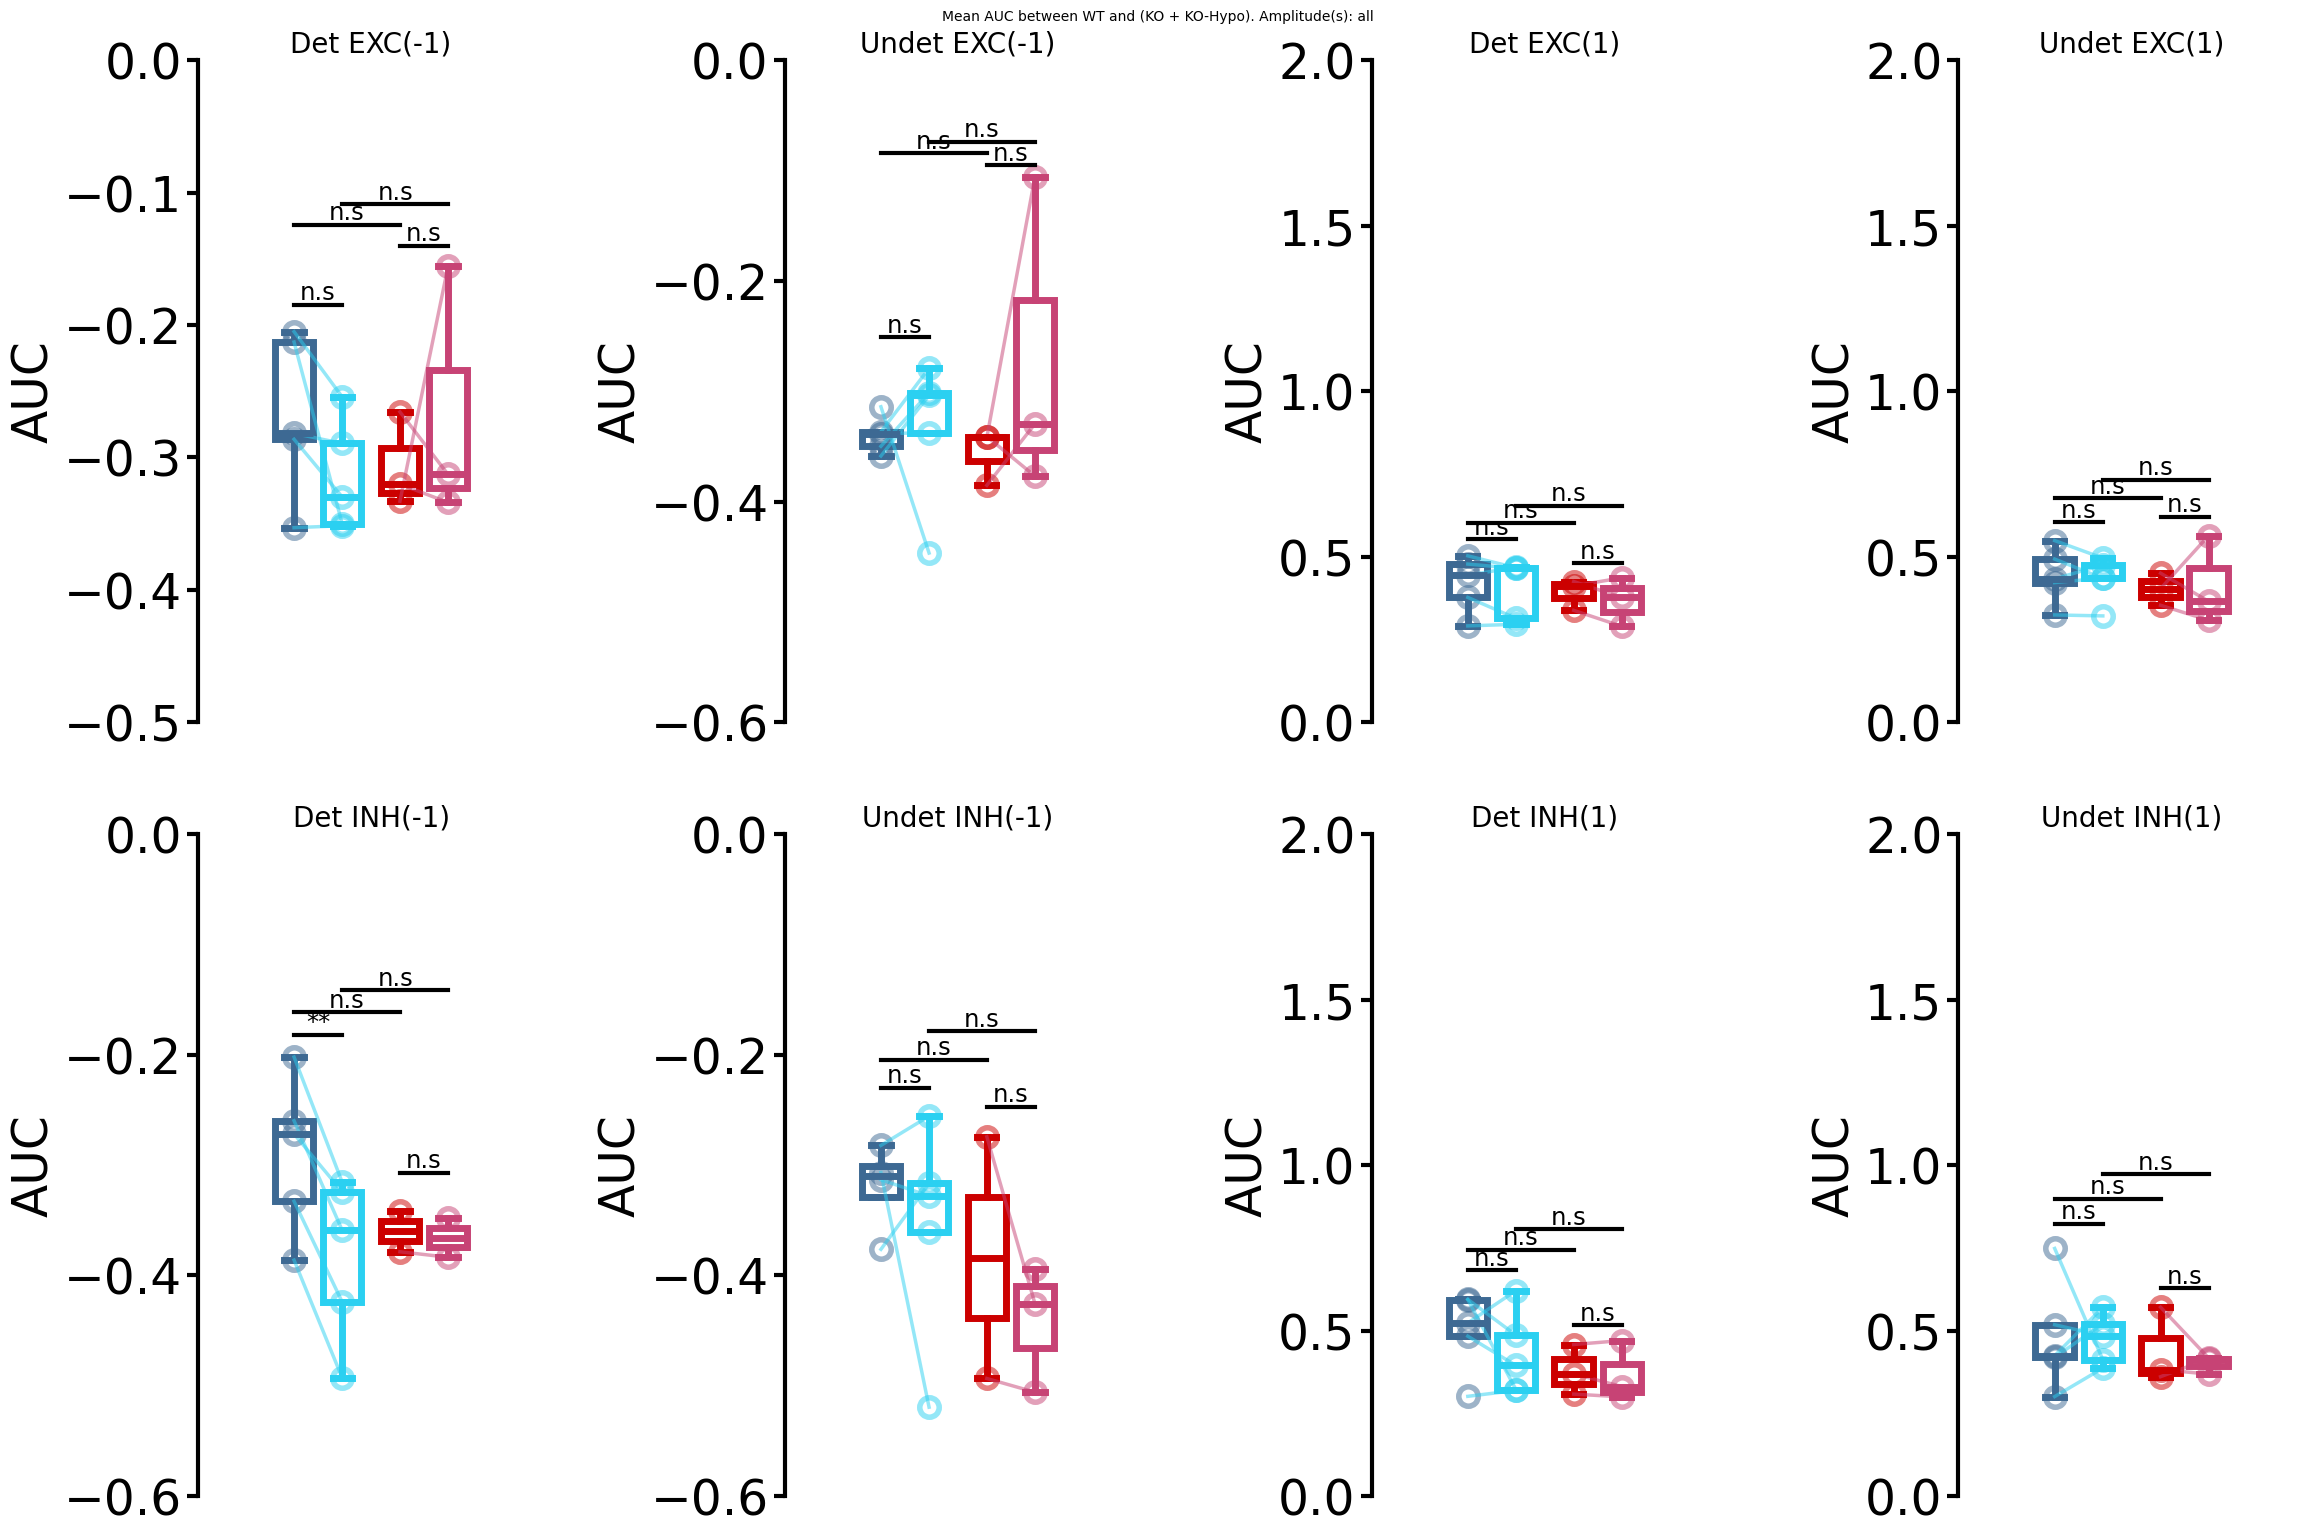

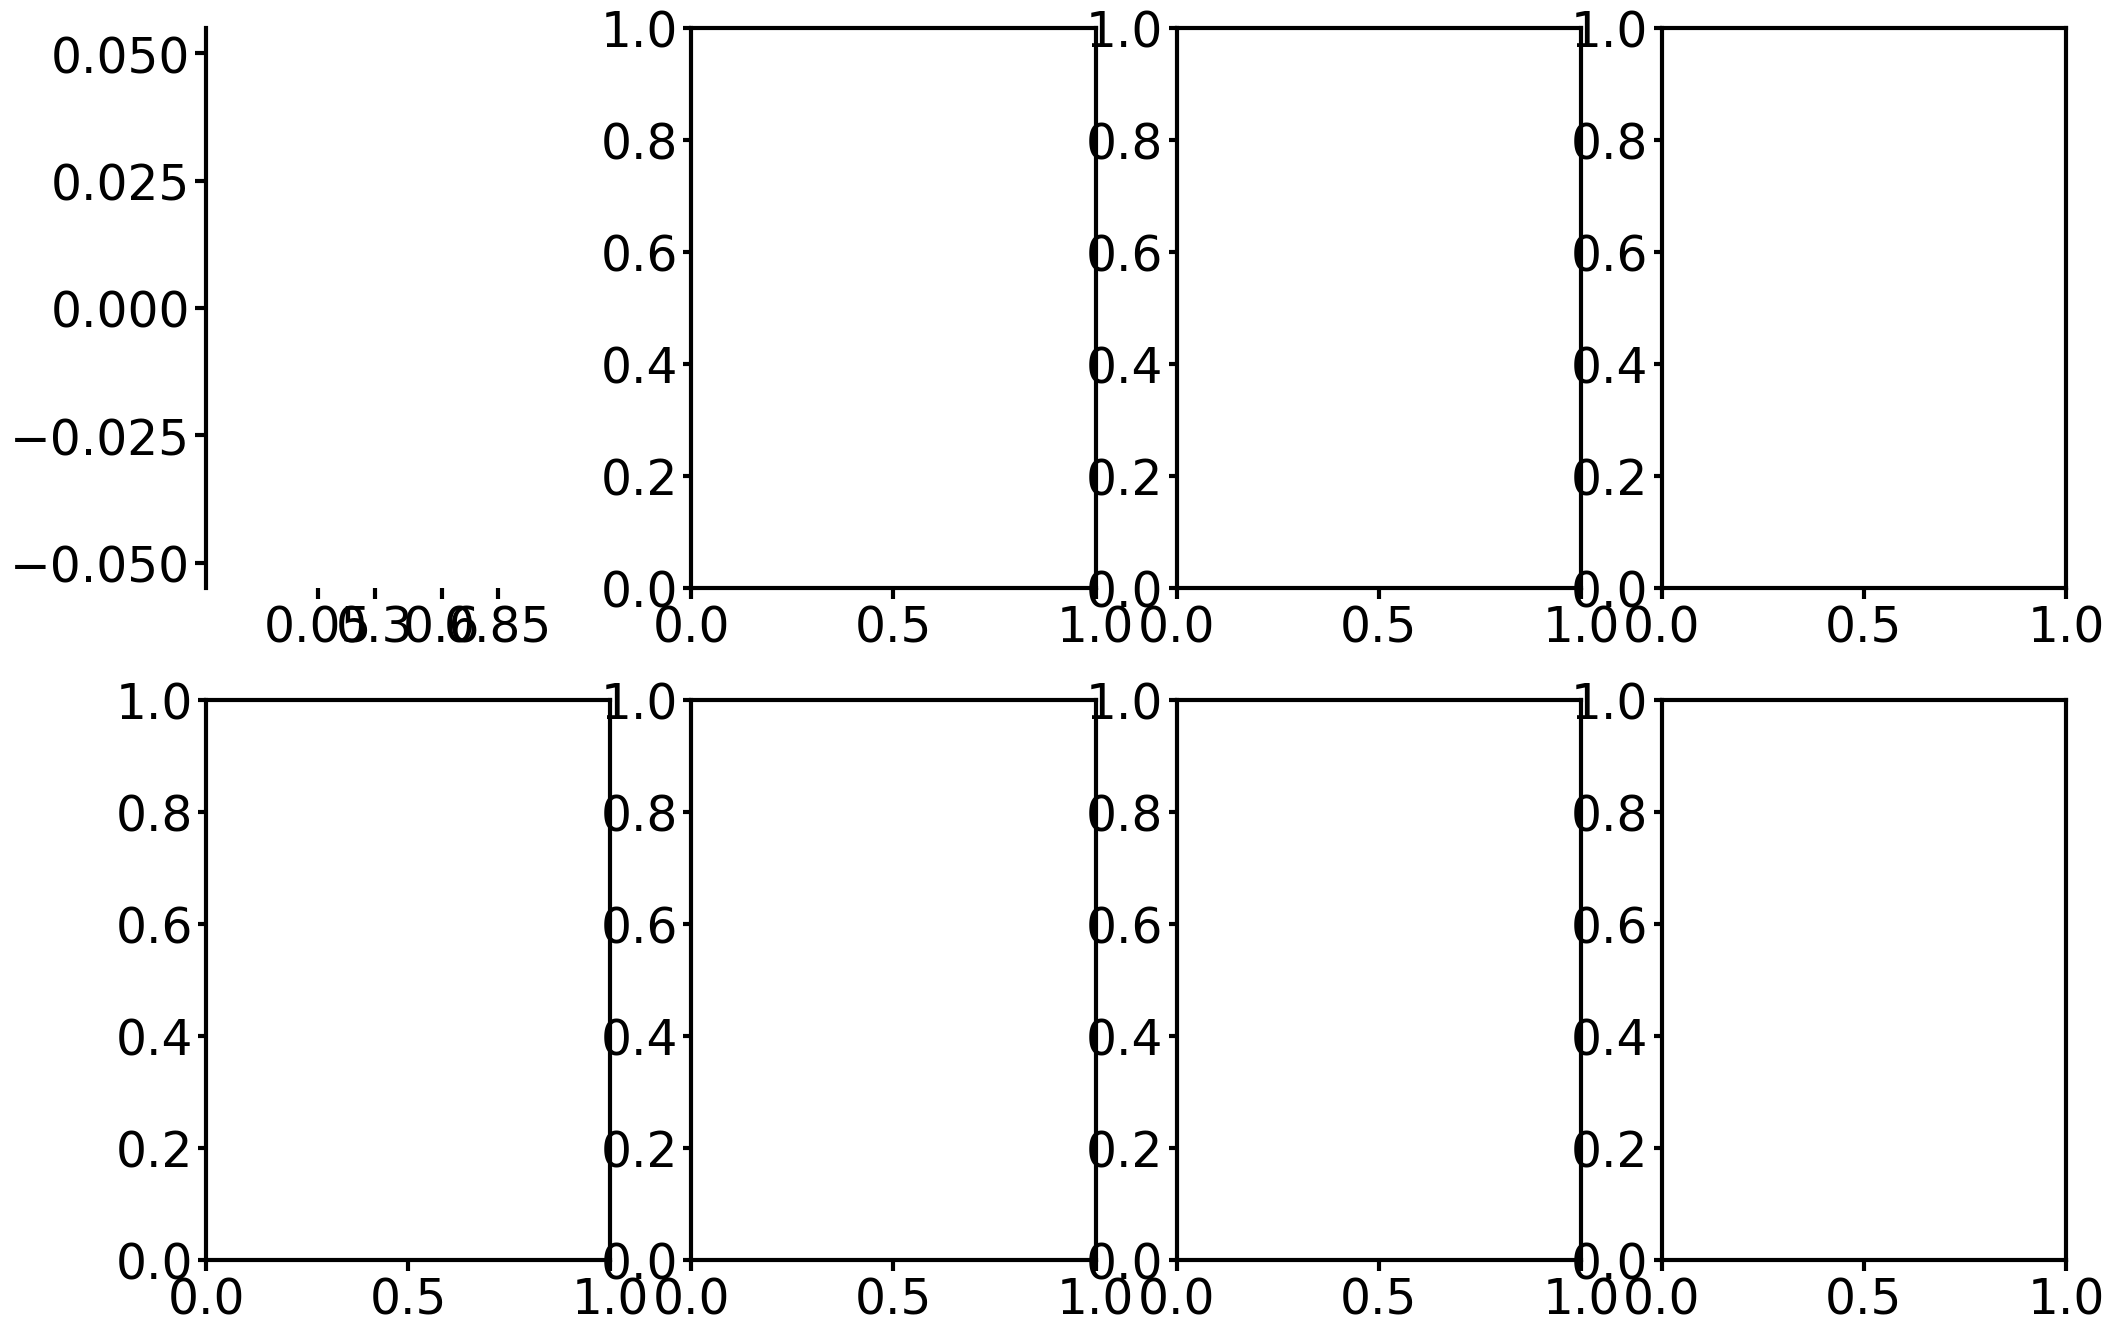

In [5]:
group_comp_param_dmso_bms(recs, "AUC", stim_ampl="all", ylim=[])
# group_comp_param_dmso_bms(recs, "AUC", stim_ampl="threshold", ylim=[])
group_comp_param_dmso_bms(recs, "AUC", stim_ampl="sub", ylim=[])
group_comp_param_dmso_bms(recs, "AUC", stim_ampl="supra", ylim=[])

In [ ]:
group_comp_param_dmso_bms(recs, "Peak_delay", stim_ampl="all", ylim=[])
# group_comp_param_dmso_bms(recs, "Peak_delay", stim_ampl="threshold", ylim=[])
group_comp_param_dmso_bms(recs, "Peak_delay", stim_ampl="sub", ylim=[])
group_comp_param_dmso_bms(recs, "Peak_delay", stim_ampl="supra", ylim=[])

In [ ]:
group_comp_param_dmso_bms(recs, "Peak_amplitude", stim_ampl="all", ylim=[])
# group_comp_param_dmso_bms(recs, "Peak_amplitude", stim_ampl="threshold", ylim=[])
group_comp_param_dmso_bms(recs, "Peak_amplitude", stim_ampl="sub", ylim=[])
group_comp_param_dmso_bms(recs, "Peak_amplitude", stim_ampl="supra", ylim=[])

In [ ]:
# def fraction_resp(pattern, n_type, stim_ampl="all", no_go_normalize=True, treatment="DMSO"):
#     wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
#     for rec in recs.values():
#         if treatment not in rec.genotype:
#             continue
#         else:
#             resp_mat = np.array(rec.matrices[n_type]["Responsivity"])
#             no_go_filter = rec.stim_ampl_filter(stim_ampl=[0], include_no_go=True)
#             ampl_filter = rec.stim_ampl_filter(stim_ampl=stim_ampl, include_no_go=False)
#             ampl_det_filt = np.logical_and(rec.detected_stim, ampl_filter)
#             ampl_undet_filt = np.logical_and(np.invert(rec.detected_stim), ampl_filter)
#             #detected
#             trials_no_go = resp_mat[:, no_go_filter]
#             trials_detected = resp_mat[:, ampl_det_filt]
#             trials_undetected = resp_mat[:, ampl_undet_filt]
#             if pattern == 0:
#                 trials_detected[trials_detected!=0]=1
#                 trials_undetected[trials_undetected!=0]=1
#                 trials_no_go[trials_no_go!=0]=1
#             else:
#                 trials_detected[trials_detected!=pattern]=0
#                 trials_undetected[trials_undetected!=pattern]=0
#                 trials_no_go[trials_no_go!=pattern]=0
#             
#             # The total number of neurons is computed
#             total_n = rec.zscore_exc.shape[0] if n_type == "EXC" else rec.zscore_inh.shape[0]
#             
#             # Computation of the number of responsive neurons
#             recruited_det = np.mean(np.count_nonzero(trials_detected, axis=0))
#             recruited_undet = np.mean(np.count_nonzero(trials_undetected, axis=0))
#             
#             # Normalization by the number of responsive neurons for no-go trials
#             if no_go_normalize:
#                 recruited_no_go = np.mean(np.count_nonzero(trials_no_go, axis=0))
#                 recruited_det -= recruited_no_go
#                 recruited_undet -= recruited_no_go
#                 recruited_det = 0 if recruited_det < 0 else recruited_det
#                 recruited_undet = 0 if recruited_undet < 0 else recruited_undet
#             
#             # Computation of the percentage of responsive neurons
#             perc_n_det = (recruited_det/total_n)*100
#             perc_n_undet = (recruited_undet/total_n)*100
#             
#             # Storing the computed percentage in the corresponding list
#             if rec.genotype == "WT-DMSO" or rec.genotype == "WT-BMS":
#                 wt_det.append(perc_n_det)
#                 wt_undet.append(perc_n_undet)
#             if rec.genotype == "KO-DMSO" or rec.genotype == "KO-BMS":
#                 ko_det.append(perc_n_det)
#                 ko_undet.append(perc_n_undet)
#     return np.array(wt_det), np.array(ko_det), np.array(wt_undet), np.array(ko_undet)